<a href="https://colab.research.google.com/github/Kaua-Rbs/Deep-Learning-From-A-To-Z-With-Pytorch-And-Python/blob/main/Project_11_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 11: Convolutional Neural Networks - MNIST

## Importing Libraries

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
torch.__version__

'2.3.0+cu121'

## Database

In [3]:
torch.manual_seed(123)

In [4]:
transform = transforms.ToTensor()

In [5]:
train = datasets.MNIST(root = '.', train = True, download=True, transform=transform)
test = datasets.MNIST(root = '.', train = False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15905222.66it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 482203.13it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3826522.04it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4162230.45it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [7]:
train.data.shape

torch.Size([60000, 28, 28])

In [9]:
train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [10]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

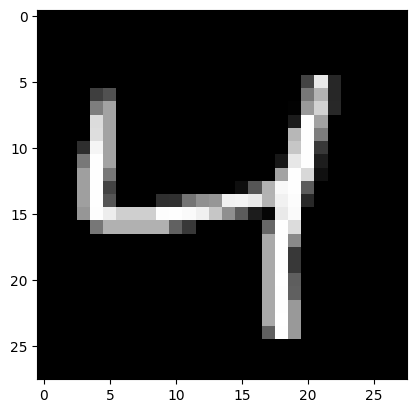

In [11]:
imagem = next(iter(train_loader))[0][2].view(28, 28) # (1, 1, 28, 28)
plt.imshow(imagem, cmap='gray')

In [12]:
imagem.shape

torch.Size([28, 28])

(array([669.,  10.,   7.,   9.,   8.,   5.,  27.,   5.,   8.,  36.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

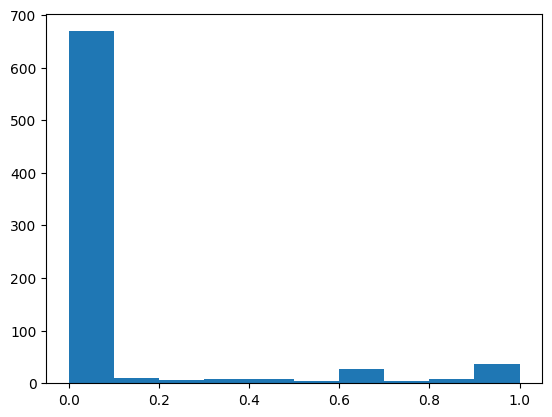

In [13]:
plt.hist(imagem.view(-1))

## Model Structuring

In [14]:
class classificador(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(32, 32, (3, 3))
    self.activation = nn.ReLU()
    self.bnorm = nn.BatchNorm2d(num_features=32)
    self.pool = nn.MaxPool2d(kernel_size = (2,2))
    self.flatten = nn.Flatten()

    # output = (input - filter + 1) / stride
    # convolução 1: (28 - 3 + 1) / 1 = 26x26
    # pooling 1: 13x13
    # convolução 2: (13 - 3 + 1) / 1 = 11x11
    # pooling 2: 5x5
    # 5 * 5 * 32
    # 800 -> 128 -> 128 -> 10
    self.linear1 = nn.Linear(in_features=32*5*5, out_features=128)
    self.linear2 = nn.Linear(128, 128)
    self.output = nn.Linear(128, 10)
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, X):
    X = self.pool(self.bnorm(self.activation(self.conv1(X))))
    X = self.pool(self.bnorm(self.activation(self.conv2(X))))
    X = self.flatten(X)

    X = self.dropout(self.activation(self.linear1(X)))
    X = self.dropout(self.activation(self.linear2(X)))
    X = self.output(X)

    return X

In [15]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## Model Training

In [19]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [20]:
net.to(device)

classificador(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [21]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.

    for i, data in enumerate(loader):
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k = 1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))

        running_accuracy += accuracy


        # Imprimindo os dados referentes a este loop
        print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1, i + 1, len(loader), loss,
                                   accuracy), end = '\r')

    # Imprimindo os dados referentes a esta época
    print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch+1, running_loss/len(loader),
                     running_accuracy/len(loader)))

In [22]:
for epoch in range(5):
  print('Treinando...')
  training_loop(train_loader, epoch)
  net.eval()
  print('Validando...')
  training_loop(test_loader, epoch)
  net.train()

Treinando...


<ipython-input-21-0aacad5ca21f>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ps = F.softmax(outputs)


ÉPOCA   1 FINALIZADA: perda 0.15786 - precisão 0.95282
Validando...
ÉPOCA   1 FINALIZADA: perda 0.15075 - precisão 0.95599
Treinando...
ÉPOCA   2 FINALIZADA: perda 0.05304 - precisão 0.98452
Validando...
ÉPOCA   2 FINALIZADA: perda 0.06297 - precisão 0.98299
Treinando...
ÉPOCA   3 FINALIZADA: perda 0.04007 - precisão 0.98812
Validando...
ÉPOCA   3 FINALIZADA: perda 0.04522 - precisão 0.98685
Treinando...
ÉPOCA   4 FINALIZADA: perda 0.03104 - precisão 0.99065
Validando...
ÉPOCA   4 FINALIZADA: perda 0.04229 - precisão 0.98665
Treinando...
ÉPOCA   5 FINALIZADA: perda 0.02495 - precisão 0.99217
Validando...
ÉPOCA   5 FINALIZADA: perda 0.02554 - precisão 0.99258


## Model Evaluation

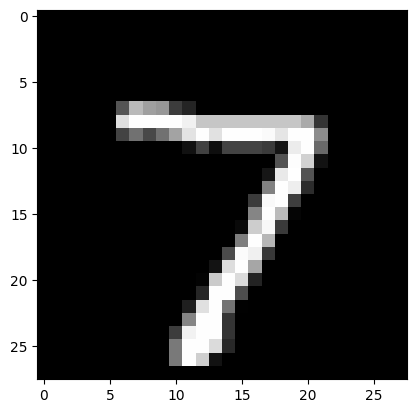

In [23]:
imagem = next(iter(test_loader))[0][0].view(28,28)
plt.imshow(imagem, cmap='gray')

In [25]:
imagem.shape

torch.Size([28, 28])

In [26]:
imagem = imagem.view(1, 1, 28, 28)
imagem.shape

torch.Size([1, 1, 28, 28])

In [27]:
net.eval()
imagem = imagem.to(device)

In [28]:
previsao = net.forward(imagem)

In [29]:
previsao

tensor([[-4.6008, -1.8608, -0.9119, -2.7076, -2.6369, -5.8012, -9.3211,  9.8312,
         -4.6990, -1.0793]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [30]:
previsao = F.softmax(previsao)

<ipython-input-30-4836b3525bc1>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  previsao = F.softmax(previsao)


In [31]:
previsao

tensor([[5.3981e-07, 8.3601e-06, 2.1593e-05, 3.5846e-06, 3.8472e-06, 1.6253e-07,
         4.8109e-09, 9.9994e-01, 4.8930e-07, 1.8265e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [32]:
previsao = previsao.cpu().detach().numpy()

In [33]:
previsao

array([[5.3981216e-07, 8.3601317e-06, 2.1593116e-05, 3.5846338e-06,
        3.8471776e-06, 1.6252740e-07, 4.8109374e-09, 9.9994314e-01,
        4.8930178e-07, 1.8265137e-05]], dtype=float32)

In [34]:
resultado = np.argmax(previsao)

In [35]:
resultado

7